Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
1. Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:

* средний удой за год — не менее 6000 килограммов;
* молоко должно быть вкусным.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score,
    mean_absolute_error,
    mean_squared_error
)

## Загрузка данных

### Загрузите данные в датафреймы pandas.

In [2]:
try:
    data_main= pd.read_csv(r'C:\Users\dinos\Downloads\ferma_main.csv', sep=';')
    data_dad= pd.read_csv(r'C:\Users\dinos\Downloads\ferma_dad.csv', sep=';')
    data_buy= pd.read_csv(r'C:\Users\dinos\Downloads\cow_buy.csv', sep=';')
    
except:
    data_main= pd.read_csv('/datasets/ferma_main.csv', sep=';')
    data_dad= pd.read_csv('/datasets/ferma_dad.csv', sep=';')
    data_buy= pd.read_csv('/datasets/cow_buy.csv', sep=';')

pd.set_option('display.max_columns', None)

In [3]:
data_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [4]:
data_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [5]:
data_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


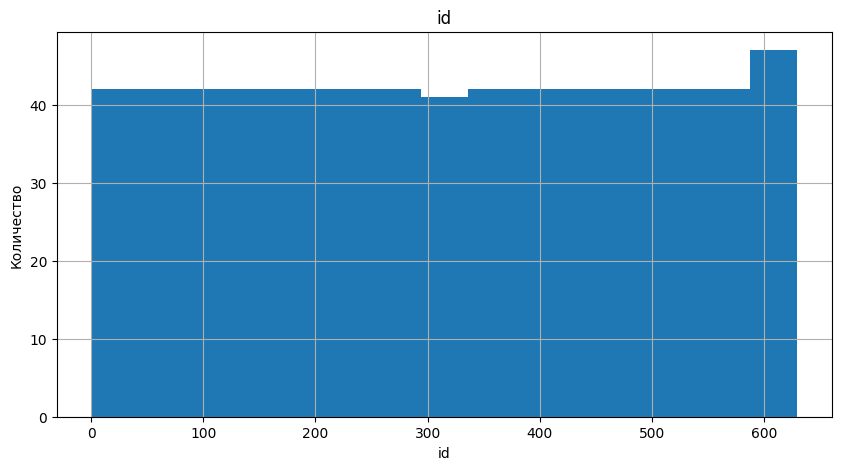

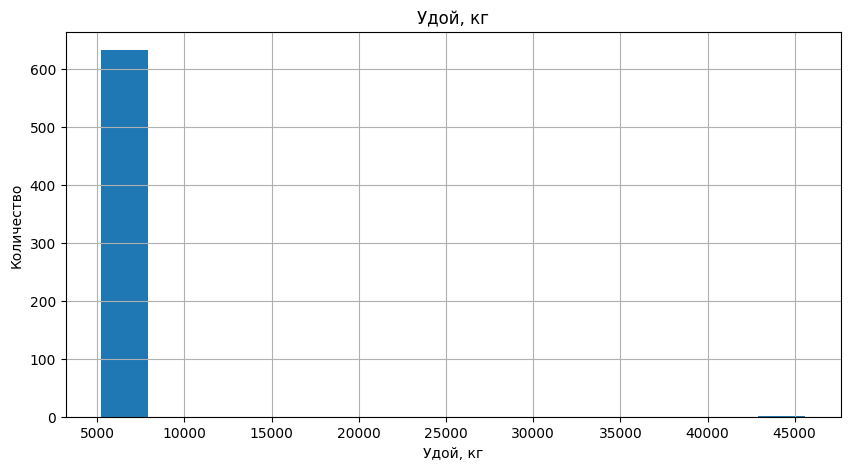

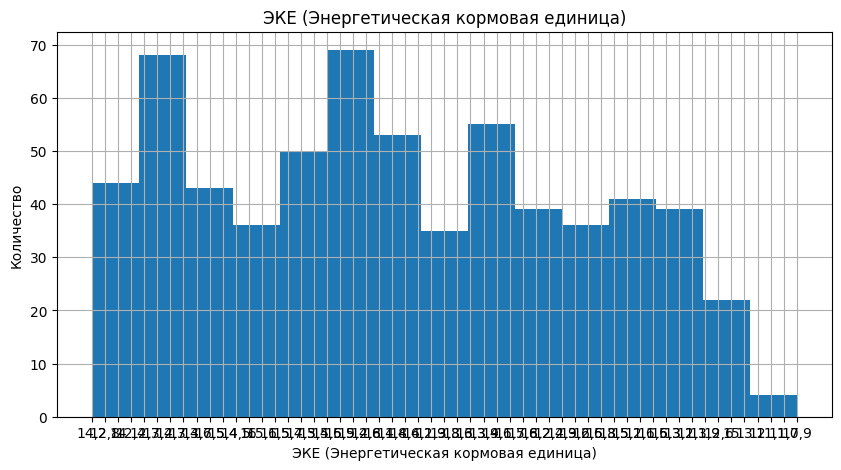

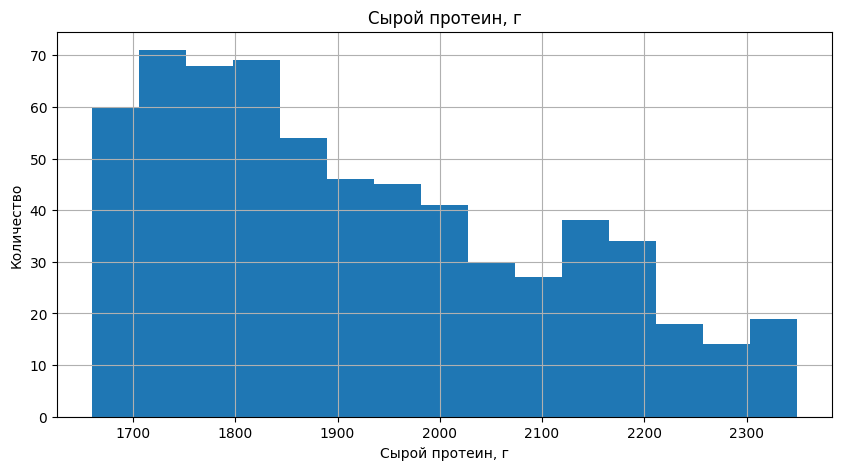

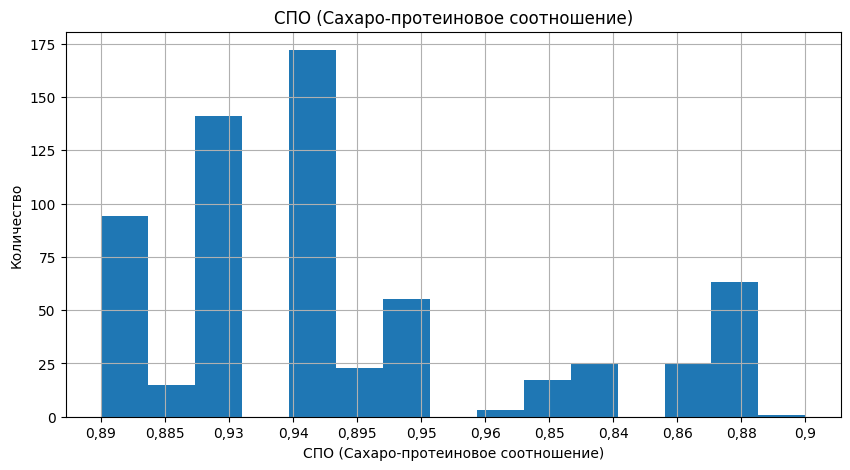

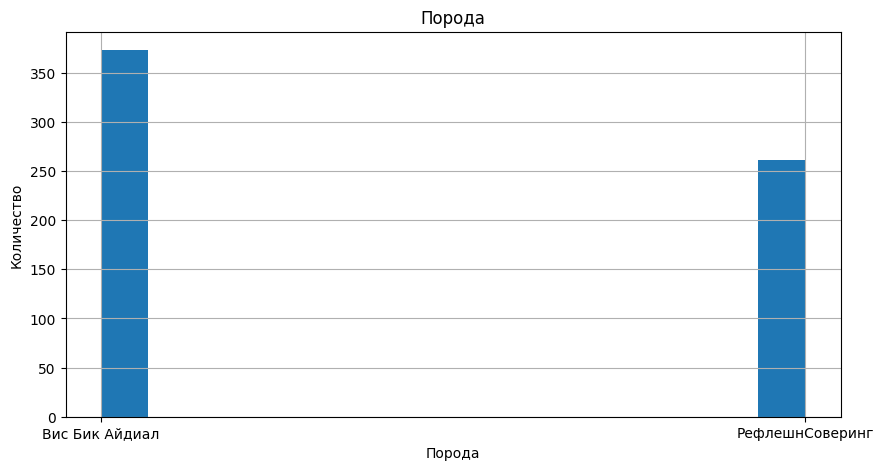

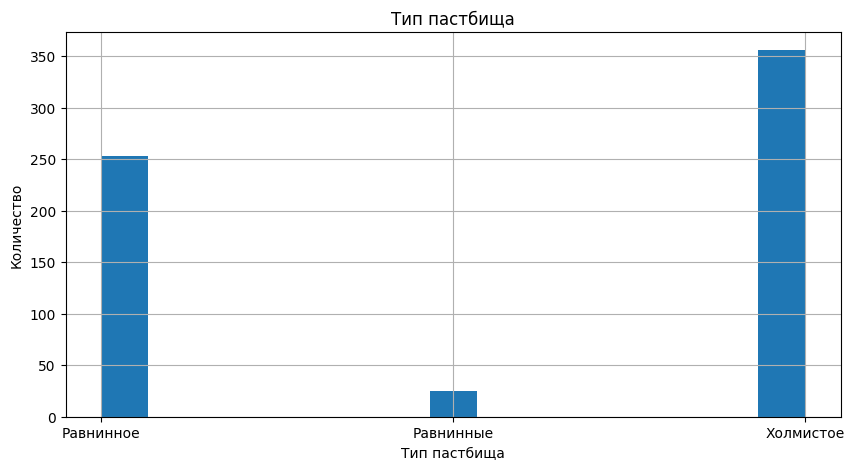

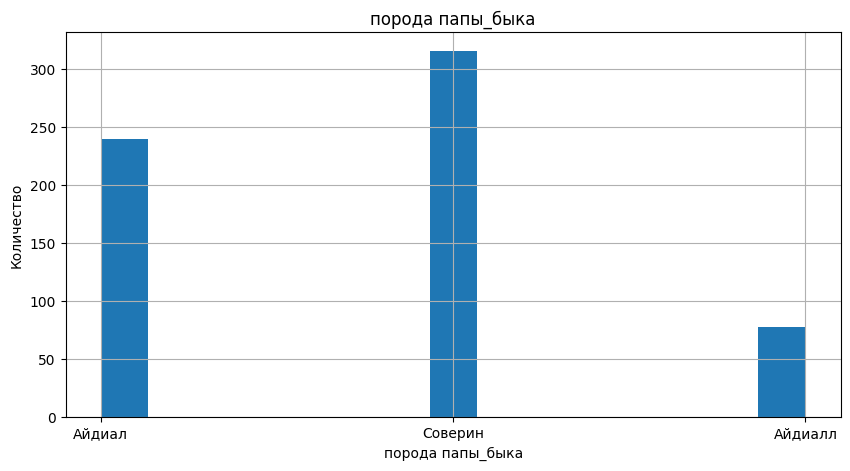

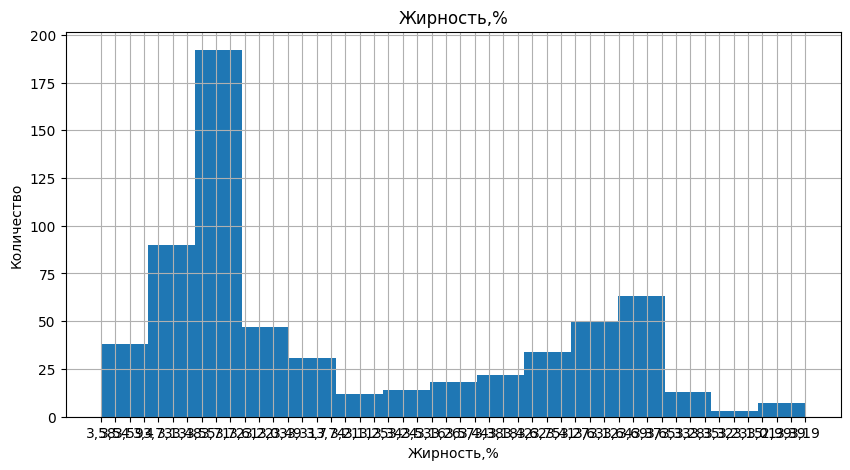

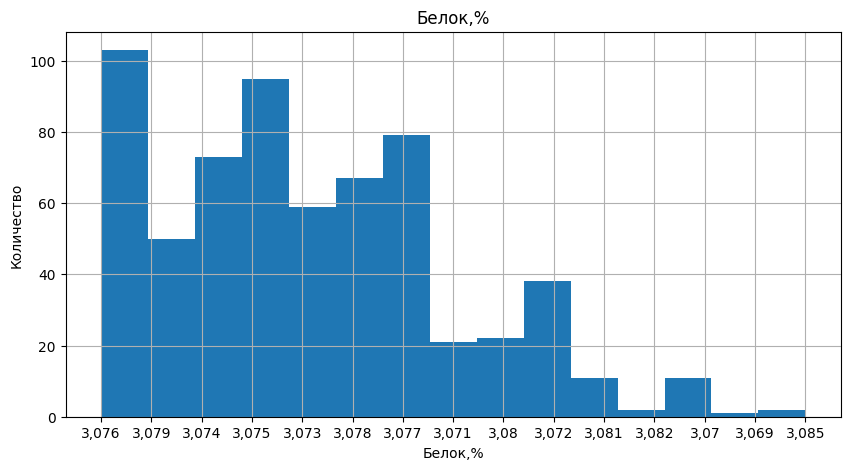

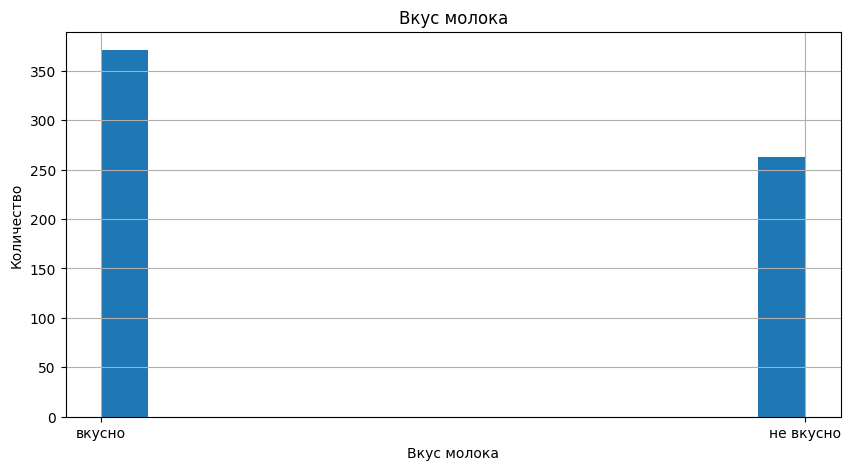

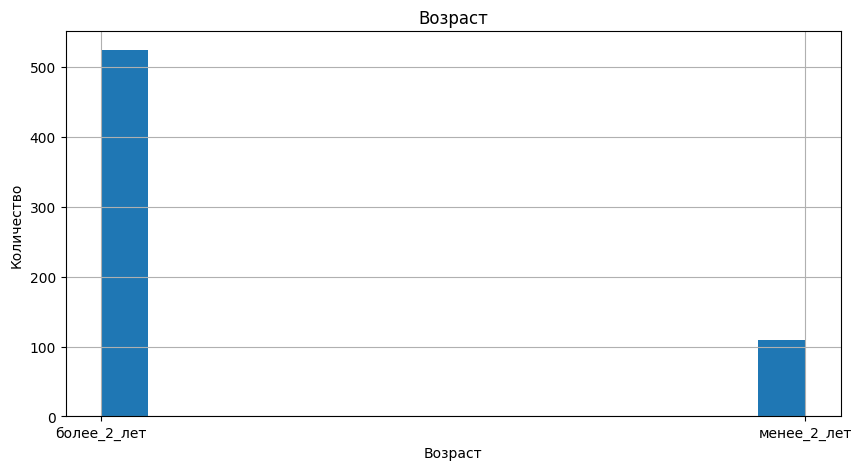

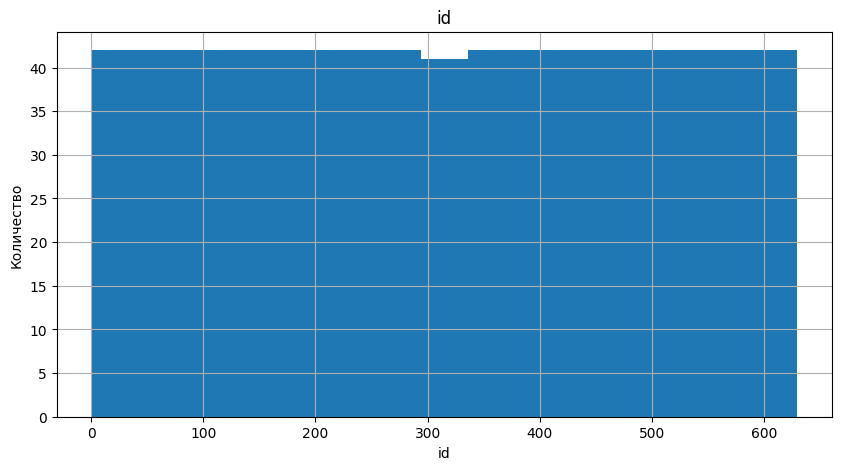

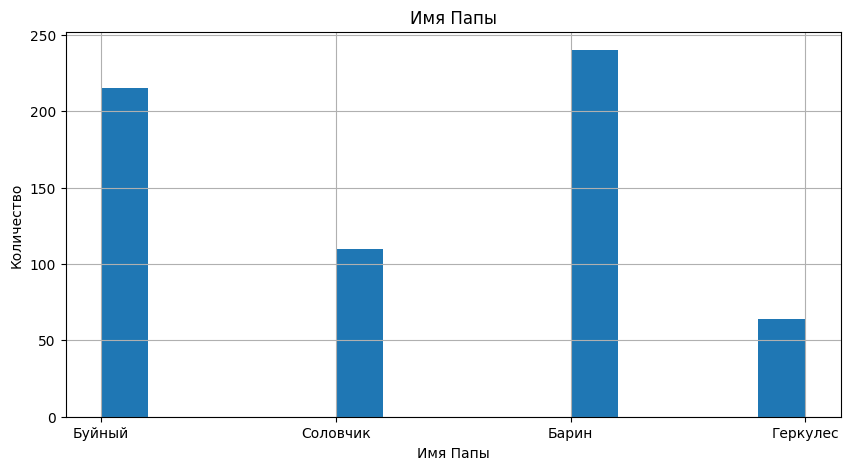

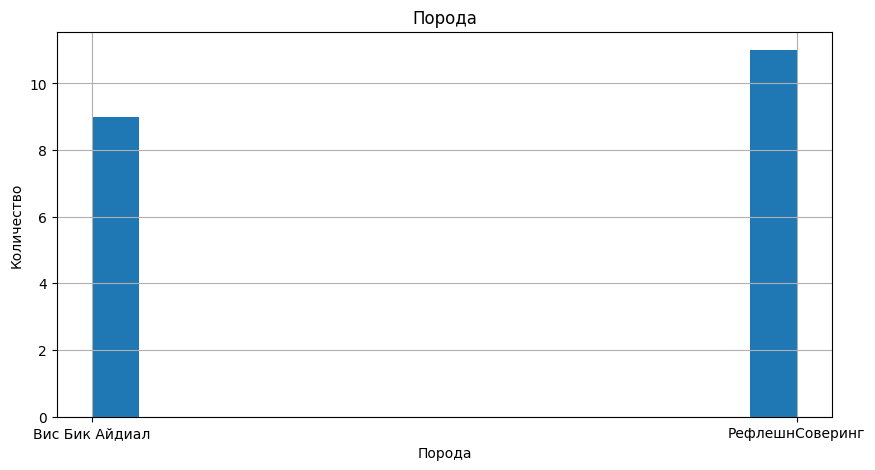

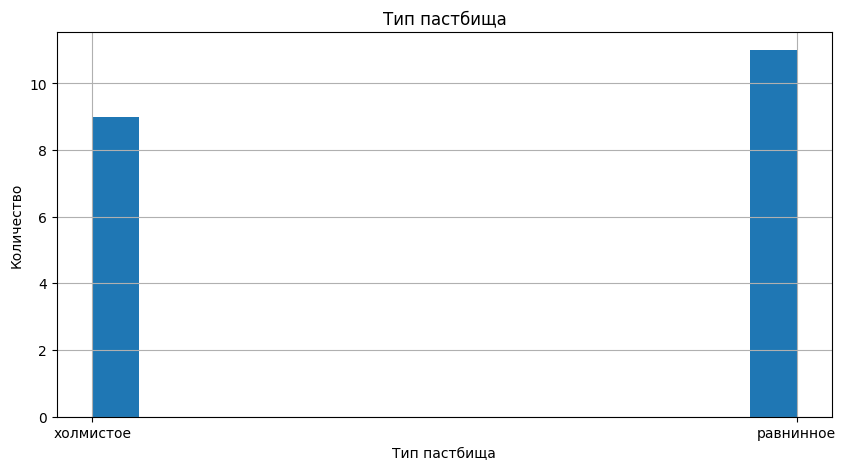

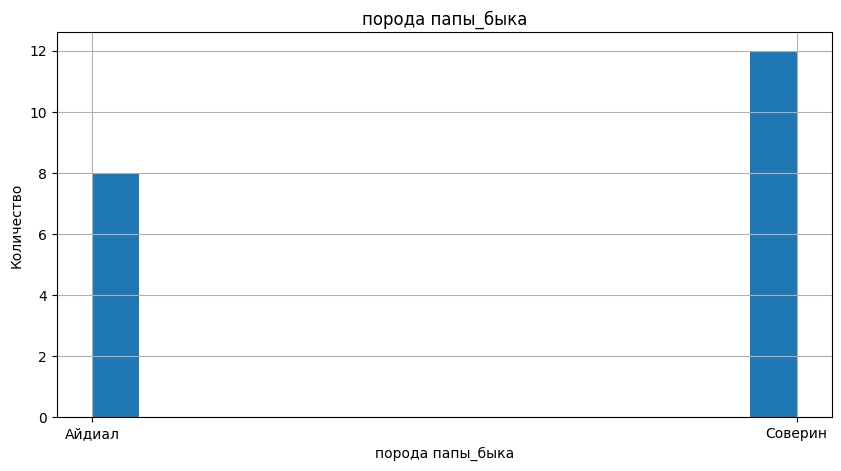

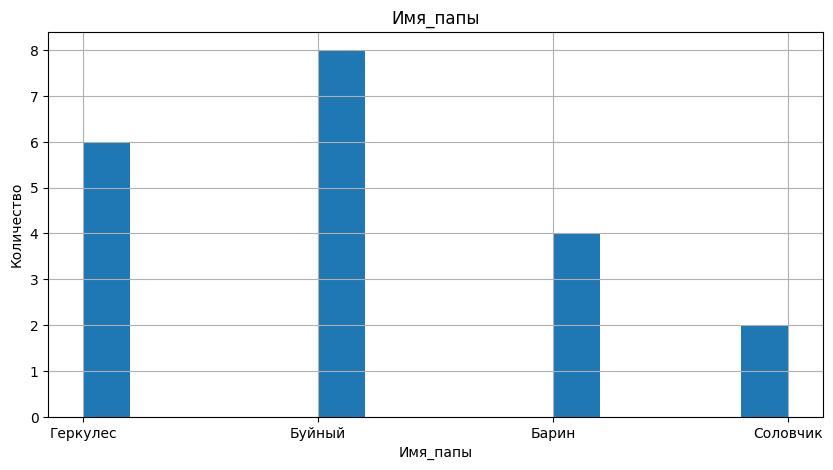

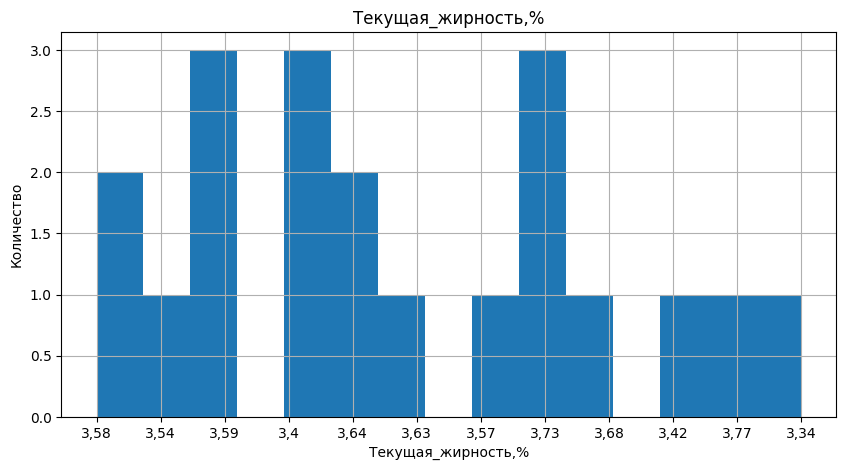

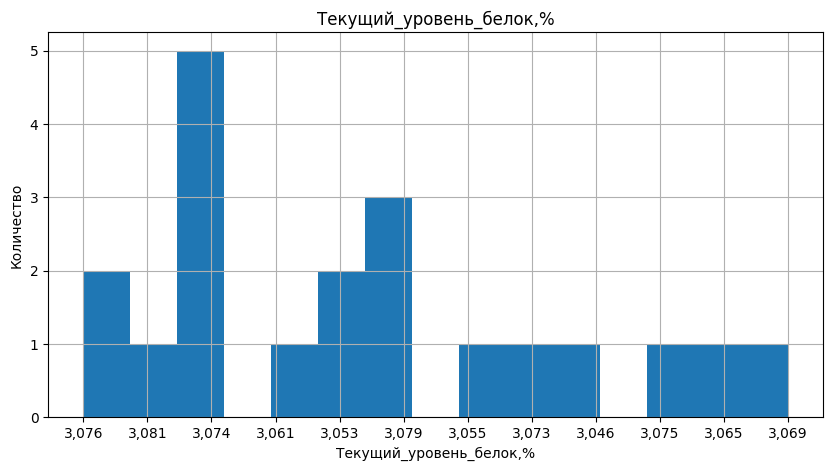

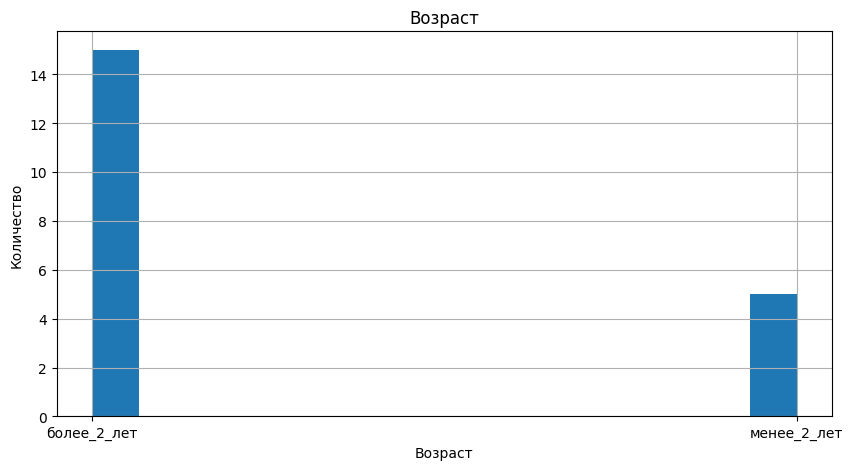

In [6]:
columns_data_main = data_main.columns
columns_data_dad = data_dad.columns
columns_data_buy = data_buy.columns

def plot_histograms(data, columns):
    for column in columns:
        plt.figure()
        data[column].hist(bins=15, figsize=(10, 5))
        plt.title(column)
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.show()

plot_histograms(data_main, columns_data_main)
plot_histograms(data_dad, columns_data_dad)
plot_histograms(data_buy, columns_data_buy)

In [7]:
def pass_value_barh(dfg):
    try:
        ax = (
            (dfg.isna().mean()*100)
            .to_frame()
            .rename(columns={0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(10,4), legend=False, fontsize=16, grid=True)
        )
        ax.set_title('Пропущенные значения, %' + "\n", fontsize=22, color='SteelBlue')
        ax.set_xlabel('Процент пропусков', fontsize=22)
        ax.set_ylabel('Столбцы с пропусками')
        plt.show()
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

пропусков не осталось :) или произошла ошибка в первой части функции 
пропусков не осталось :) или произошла ошибка в первой части функции 
пропусков не осталось :) или произошла ошибка в первой части функции 


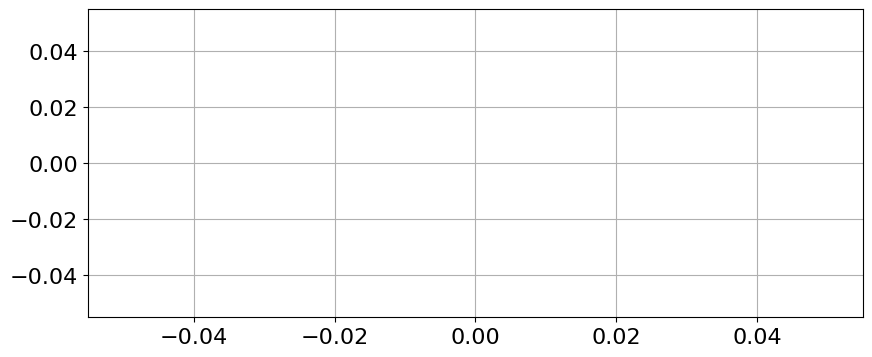

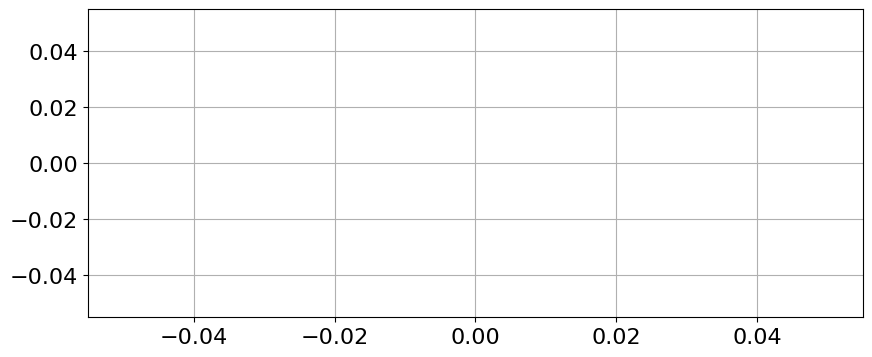

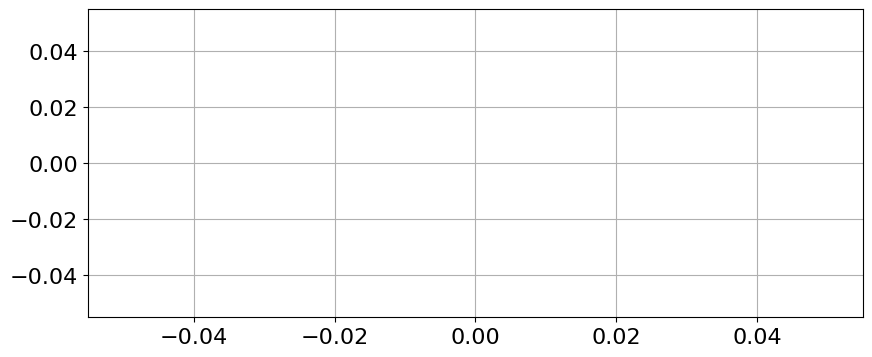

In [8]:
pass_value_barh(data_main)
pass_value_barh(data_dad)
pass_value_barh(data_buy)

In [9]:
print(data_main.shape)
data_main.info()

(634, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст  

In [10]:
print(data_dad.shape)
data_dad.info()

(629, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [11]:
print(data_buy.shape)
data_buy.info()

(20, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


Предворительно можно сказать что:
* Пропуски в данных отсуствуют
* Столбцы ЭКЕ, СПО, Жирность и Белок требуется перевести в тип float
* В столбце Удой имеются выбросы
* Названия столбцов начинаются с заглавной буквы, а так же содержат в себе лишнию для дальнешей работы расшифровку в скобках


### Изучите данные. Определите, соответствуют ли они описанию задачи и изученным в прошлых спринтах стандартам оформления данных. При необходимости переименуйте столбцы.

In [12]:
def convert_columns_to_lowercase(data):
    for df in data:
        df.rename(columns=str.lower, inplace=True)
dataframes = [data_main, data_buy, data_dad]
convert_columns_to_lowercase(dataframes)

In [13]:

data_main = data_main.rename(columns={'эке (энергетическая кормовая единица)':'эке', 'спо (сахаро-протеиновое соотношение)':'спо'})

##  Предобработка данных

### Проверьте данные на наличие пропусков и дубликатов. Узнайте, корректны ли типы данных у каждого признака. При необходимости устраните все проблемы с данными.

#### Проверка на дубликаты

In [14]:
def duplicates(data):
    return data.duplicated().sum()
print(duplicates(data_main))
print(duplicates(data_buy))
duplicates(data_dad)

5
4


0

In [15]:
data_main = data_main.drop_duplicates()
print(duplicates(data_main))

0


#### Проверка на неявные дубликаты

In [16]:
columns = ['вкус молока', 'возраст', 'порода', 'тип пастбища', 'порода папы_быка']

for column in columns:
    print(data_main[column].value_counts())
    print('\n')

вкус молока
вкусно       371
не вкусно    258
Name: count, dtype: int64


возраст
более_2_лет    519
менее_2_лет    110
Name: count, dtype: int64


порода
Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: count, dtype: int64


тип пастбища
Холмистое    351
Равнинное    253
Равнинные     25
Name: count, dtype: int64


порода папы_быка
Соверин    311
Айдиал     240
Айдиалл     78
Name: count, dtype: int64




In [17]:
data_main = data_main.replace('Равнинные', 'Равнинное')
data_main.value_counts('тип пастбища')

тип пастбища
Холмистое    351
Равнинное    278
Name: count, dtype: int64

In [18]:
data_main = data_main.replace('Айдиалл', 'Айдиал')
data_main.value_counts('порода папы_быка')

порода папы_быка
Айдиал     318
Соверин    311
Name: count, dtype: int64

In [19]:
columns = ['порода', 'тип пастбища', 'порода папы_быка', 'имя_папы', 'возраст']

for column in columns:
    print(data_buy[column].value_counts())
    print('\n')

порода
РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: count, dtype: int64


тип пастбища
равнинное    11
холмистое     9
Name: count, dtype: int64


порода папы_быка
Соверин    12
Айдиал      8
Name: count, dtype: int64


имя_папы
Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: count, dtype: int64


возраст
более_2_лет    15
менее_2_лет     5
Name: count, dtype: int64




In [20]:
data_buy = data_buy.copy()
data_buy.loc[:, 'тип пастбища'] = data_buy['тип пастбища'].str.title()
data_buy['тип пастбища'].head()

0    Холмистое
1    Равнинное
2    Равнинное
3    Холмистое
4    Равнинное
Name: тип пастбища, dtype: object

In [21]:
data_dad.value_counts('имя папы')

имя папы
Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: count, dtype: int64

#### Перевод данных в нужные типы

In [22]:
def process_data(data_main, data_buy):
    main_columns = [
        'эке',
        'спо',
        'жирность,%', 
        'белок,%'
    ]
    buy_columns = [
        'текущая_жирность,%',
        'текущий_уровень_белок,%'
    ]

    for col in main_columns:
        data_main[col] = data_main[col].str.replace(',', '.').astype('float')

    for col in buy_columns:
        data_buy[col] = data_buy[col].str.replace(',', '.').astype('float')
    
    return data_main, data_buy

process_data(data_main, data_buy)

data_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                629 non-null    int64  
 1   удой, кг          629 non-null    int64  
 2   эке               629 non-null    float64
 3   сырой протеин, г  629 non-null    int64  
 4   спо               629 non-null    float64
 5   порода            629 non-null    object 
 6   тип пастбища      629 non-null    object 
 7   порода папы_быка  629 non-null    object 
 8   жирность,%        629 non-null    float64
 9   белок,%           629 non-null    float64
 10  вкус молока       629 non-null    object 
 11  возраст           629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.9+ KB


In [23]:
data_main.head()

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет


In [24]:
data_main['вкус молока'] = data_main['вкус молока'].apply(lambda x: 1 if x == 'вкусно' else 0)

data_main['вкус молока'] = data_main['вкус молока'].astype(float)
data_main['вкус молока'].value_counts()

1.0    371
0.0    258
Name: вкус молока, dtype: int64

In [25]:
data_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   порода                   20 non-null     object 
 1   тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   имя_папы                 20 non-null     object 
 4   текущая_жирность,%       20 non-null     float64
 5   текущий_уровень_белок,%  20 non-null     float64
 6   возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


Была произведена предообработка данных:
* Преобразован тип данных в столбцах 'ЭКЕ', 'СПО', 'Жирность,%', 'Белок,%' с категориального на числовой формат.
* Исправлены данные с неявными дубликатами.
* Удалены дубликаты: 5 строк из данных по фермерскому стаду и 4 строки из данных по покупаемому стаду.
* Изменены значения в столбце "вкус молока".

## Исследовательский анализ данных

### Проведите статистический анализ всех признаков.

In [26]:
data_main.describe()

,id,"удой, кг",эке,"сырой протеин, г",спо,"жирность,%","белок,%",вкус молока
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671,0.589825
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549,0.492257
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000,0.000000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000,0.000000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000,1.000000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000,1.000000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000,1.000000


In [27]:
data_buy.describe()

,"текущая_жирность,%","текущий_уровень_белок,%"
count,20.000000,20.000000
mean,3.577500,3.069500
std,0.126818,0.010339
min,3.340000,3.046000
25%,3.510000,3.064000
50%,3.590000,3.074000
75%,3.650000,3.076000
max,3.770000,3.081000


### Постройте графики для каждого признака. Помните, что количественным и категориальным признакам подходят разные графики.

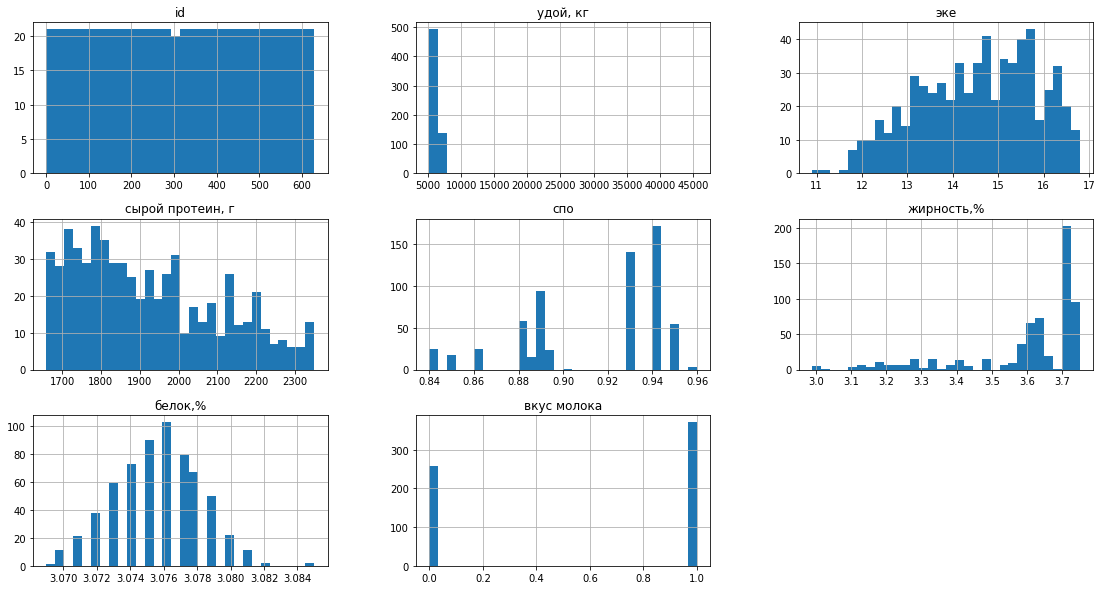

In [28]:
#data_main['удой, кг'].hist(bins=100)
data_main.hist(grid=True, figsize=(19, 10), bins=30);

In [29]:
data_main[data_main['удой, кг'] > 10000]

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.076,1.0,более_2_лет


In [30]:
data_main = data_main.drop(index= 16)

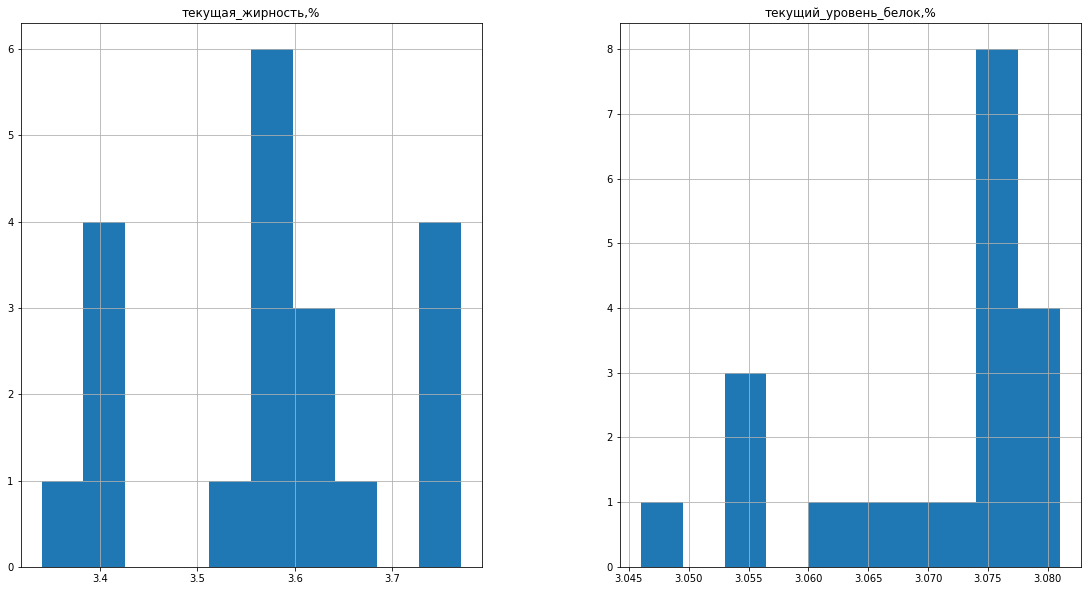

In [31]:
data_buy.hist(grid=True, figsize=(19, 10));

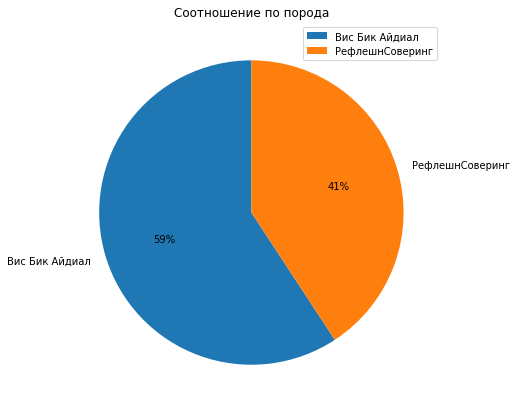

порода
Вис Бик Айдиал     59.24
РефлешнСоверинг    40.76


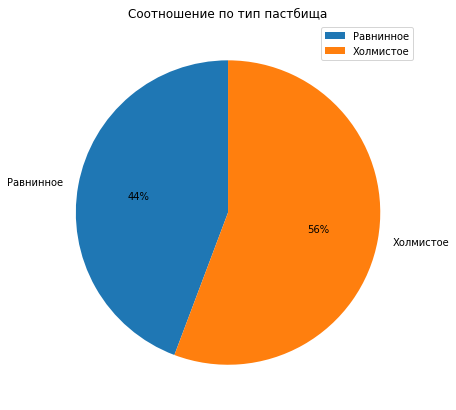

тип пастбища
Холмистое    55.73
Равнинное    44.27


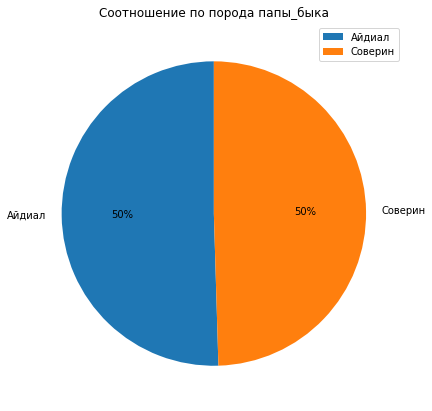

порода папы_быка
Айдиал     50.48
Соверин    49.52


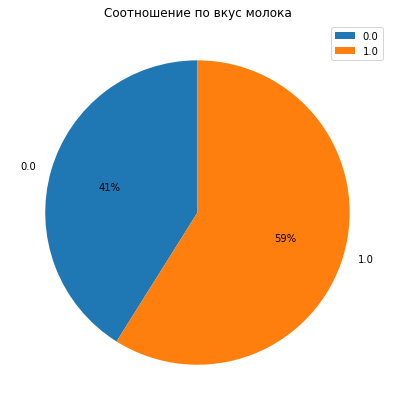

вкус молока
1.0    58.92
0.0    41.08


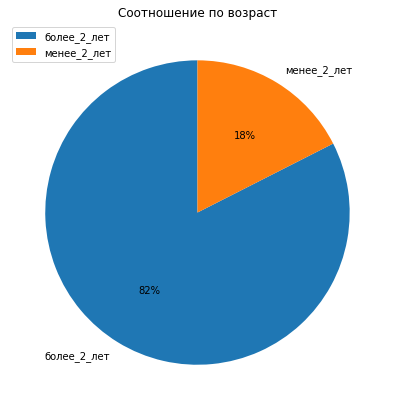

возраст
более_2_лет    82.48
менее_2_лет    17.52


In [32]:
def plot_and_print_distribution(data, columns):
    for column in columns:
        data.pivot_table(index=column, values='id', aggfunc='count') \
            .plot.pie(y='id', figsize=(10,7), label='', title=f'Соотношение по {column}', autopct = "%.0f%%", startangle=90)
        plt.show()

        distribution = (data.groupby(column).size() / len(data) * 100).sort_values(ascending=False).round(2)
        print(distribution.to_string(index=True))

# Specify the columns
columns = ['порода', 'тип пастбища', 'порода папы_быка', 'вкус молока', 'возраст']

# Call the function
plot_and_print_distribution(data_main, columns)

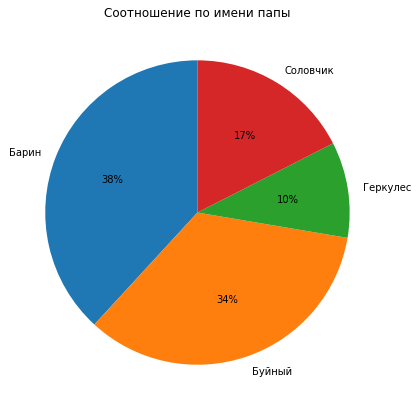

имя папы
Барин       38.16
Буйный      34.18
Соловчик    17.49
Геркулес    10.17
dtype: float64


In [33]:
data_dad.groupby('имя папы').size().plot.pie(figsize=(10,7), label='', title='Соотношение по имени папы', autopct = "%.0f%%", startangle=90)
plt.show()
print((data_dad.groupby('имя папы').size() / len(data_dad) * 100).sort_values(ascending=False).round(2))

### Сделайте выводы о данных:
* напишите, заметили ли вы выбросы, необычное распределение количественных признаков или другие особенности;
* расскажите, как вы планируете улучшить данные.

Была выполнена предобработка данных:

- Проверены пропуски в таблицах, и они не были обнаружены.
- Проверены данные на наличие выбросов
- Исправлены данные с неявными дубликатами.
- Удалены дубликаты: 5 строк из данных по фермерскому стаду.
- Изменены значения в столбце "вкус молока".

## Корреляционный анализ

### Изучите взаимосвязь между признаками: рассчитайте коэффициенты корреляции между всеми признаками.

In [34]:
#pd.plotting.scatter_matrix(data_main, figsize=(15, 15));
data_main.corr()

,id,"удой, кг",эке,"сырой протеин, г",спо,"жирность,%","белок,%",вкус молока
id,1.000000,-0.006816,-0.028600,-0.035613,-0.064803,0.017126,0.002547,-0.071675
"удой, кг",-0.006816,1.000000,0.765098,0.446731,0.806339,0.600902,0.002966,0.112839
эке,-0.028600,0.765098,1.000000,0.387875,0.749007,0.637279,-0.008939,0.214418
"сырой протеин, г",-0.035613,0.446731,0.387875,1.000000,0.446332,0.357793,0.226802,0.148606
спо,-0.064803,0.806339,0.749007,0.446332,1.000000,0.629098,0.073718,0.189197
"жирность,%",0.017126,0.600902,0.637279,0.357793,0.629098,1.000000,-0.026542,0.094251
"белок,%",0.002547,0.002966,-0.008939,0.226802,0.073718,-0.026542,1.000000,0.128186
вкус молока,-0.071675,0.112839,0.214418,0.148606,0.189197,0.094251,0.128186,1.000000


<AxesSubplot:>

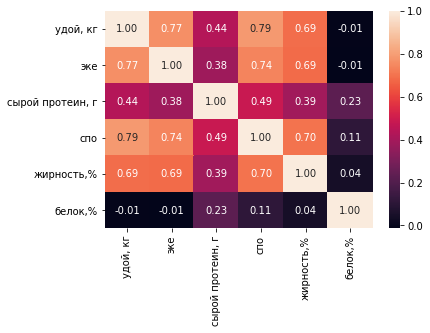

In [35]:
sns.heatmap(data_main[['удой, кг', 'эке', 'сырой протеин, г', 'спо','жирность,%', 'белок,%']].corr(method="spearman"), annot=True, fmt='.2f')


In [36]:
data_buy.corr()

,"текущая_жирность,%","текущий_уровень_белок,%"
"текущая_жирность,%",1.000000,-0.262722
"текущий_уровень_белок,%",-0.262722,1.000000


### Постройте диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков. 

Пример: диаграмма рассеяния для Удой, кг и Сырой протеин, г, цвет точек диаграммы отображает признак Порода. Учитывайте, что виды связи в подгруппах могут различаться — например, для разных пород.

In [37]:
main_cat = ['порода', 'тип пастбища', 'порода папы_быка', 'вкус молока', 'возраст']
main_num = ['эке', 'сырой протеин, г', 'спо', 'жирность,%', 'белок,%']


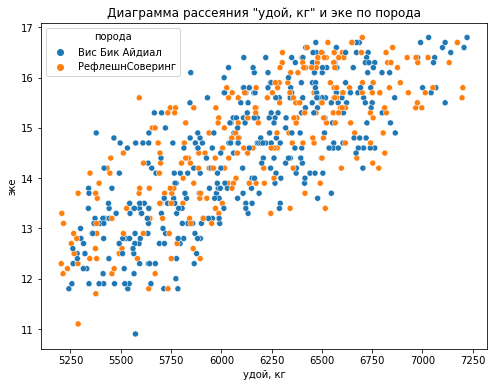

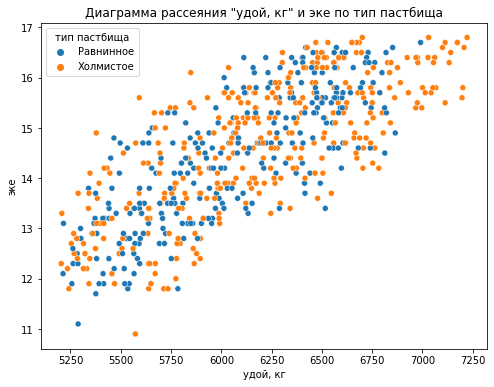

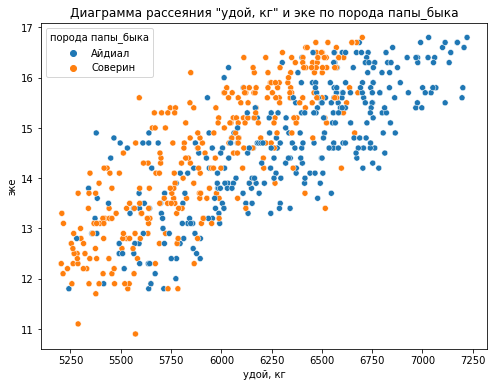

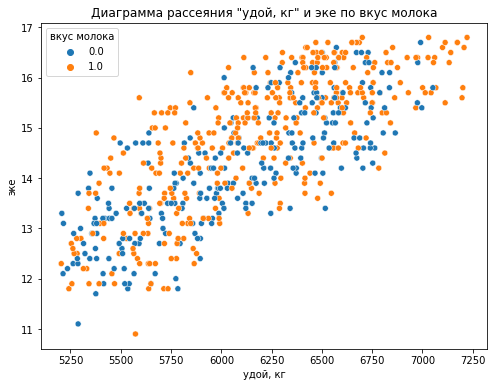

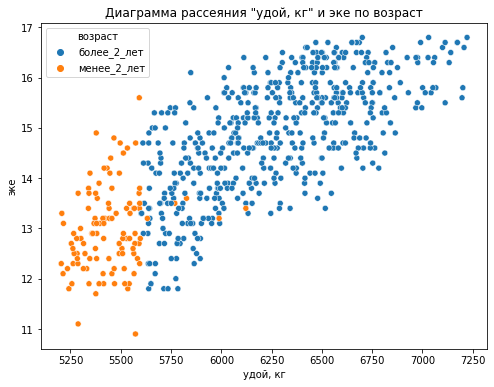

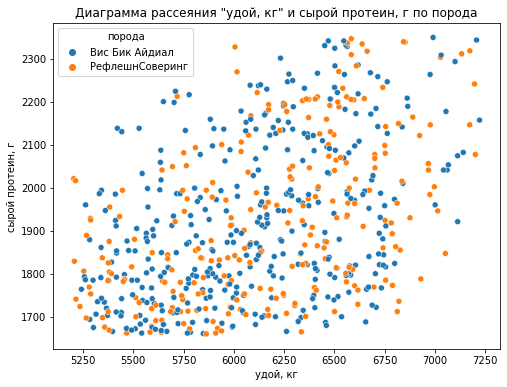

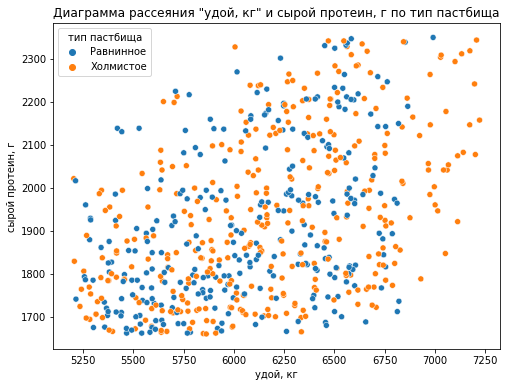

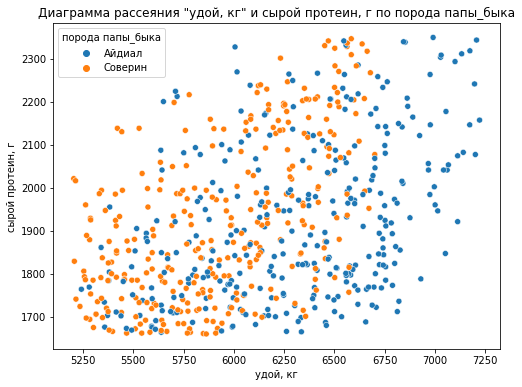

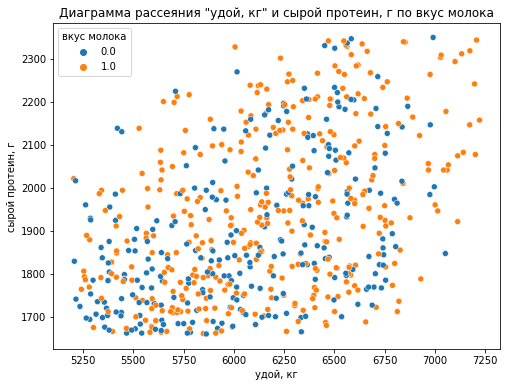

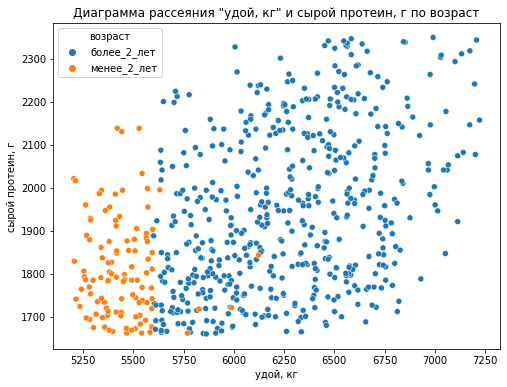

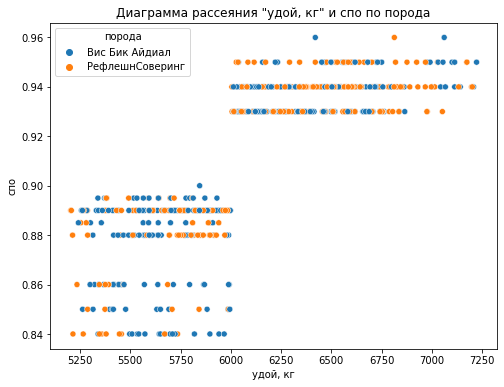

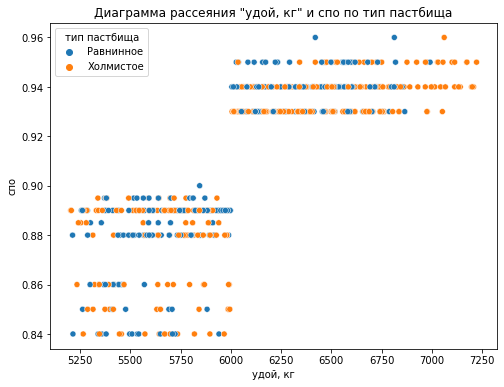

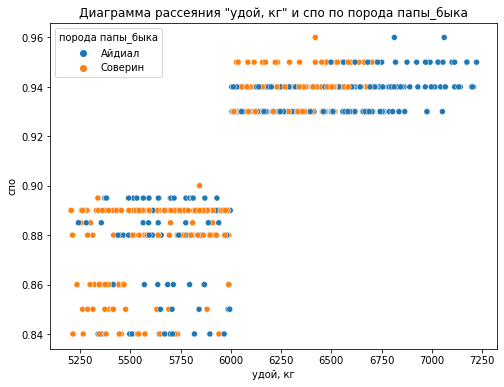

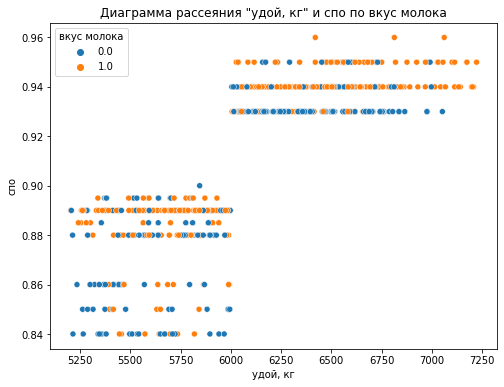

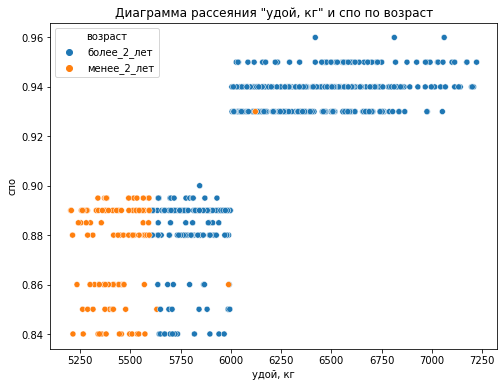

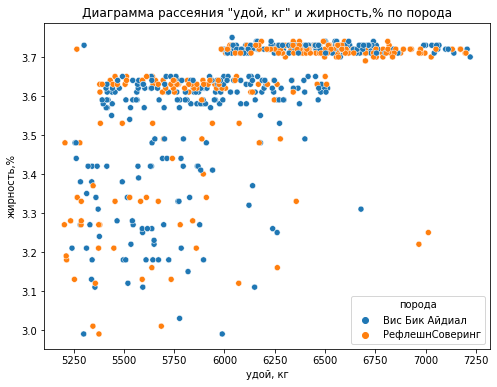

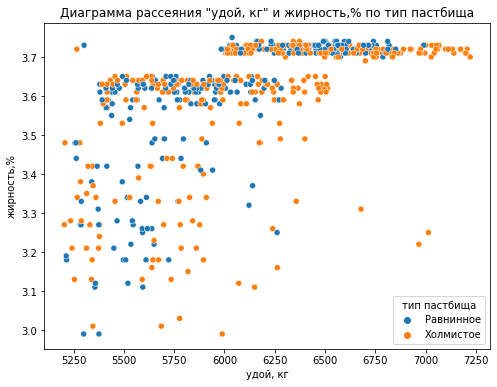

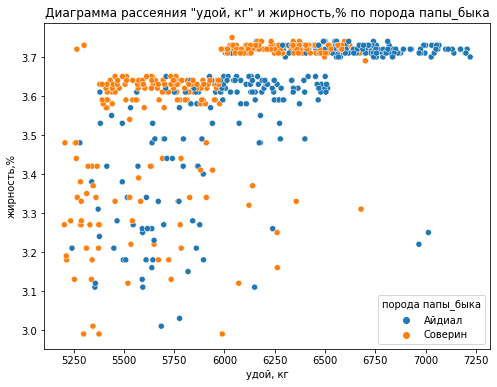

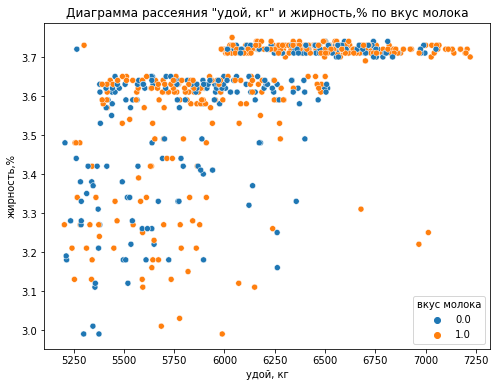

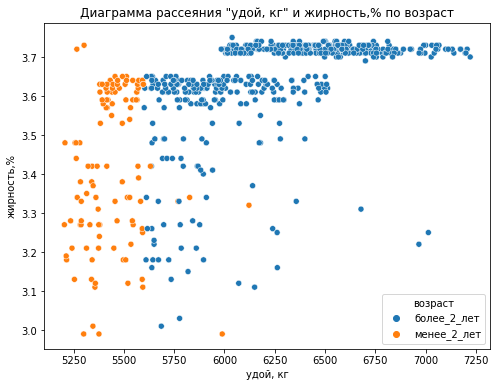

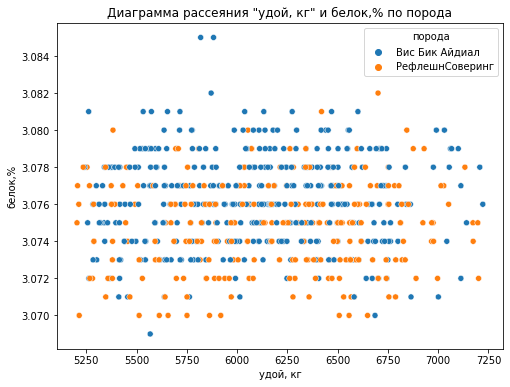

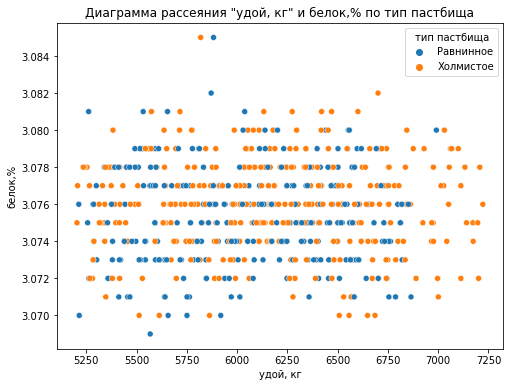

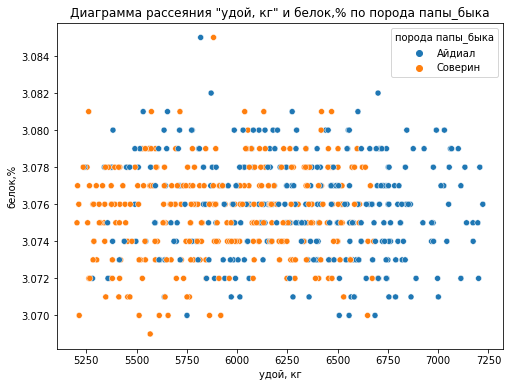

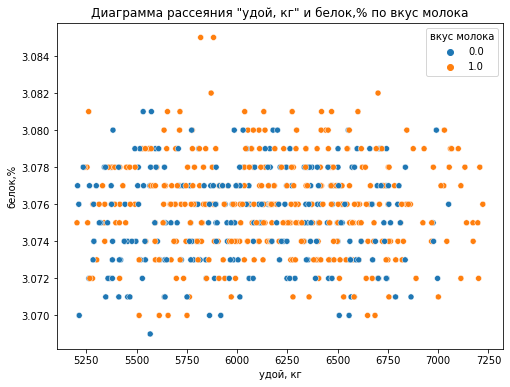

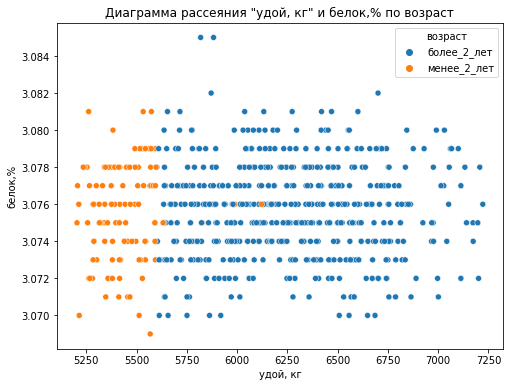

In [38]:
for y_val in main_num:
    for hue_val in main_cat:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=data_main, x="удой, кг", y=y_val, hue=hue_val)
        plt.title(f'Диаграмма рассеяния "удой, кг" и {y_val} по {hue_val}')
        plt.show()

### Сделайте выводы о взаимосвязи признаков.
* Какой тип взаимосвязи между целевым и входными признаками?
* Есть ли нелинейные связи между целевым и входными признаками? Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?
* Наблюдается ли мультиколлинеарность между входными признаками?

Корреляция с удоем:
* ЭК. Между удоем и ЭК сильная корреляция. На размер удоя влияет потомство и возраст коровы. Потомство породы Айдана более чуствительно к ЭКЕ, увеличивая колиство молока. Коровы до двух лет дают от 5200 до 5600 не зависимо от ЭКЕ, старшие особи дают от 5600 и так же есть положительная связь с ЭКЕ
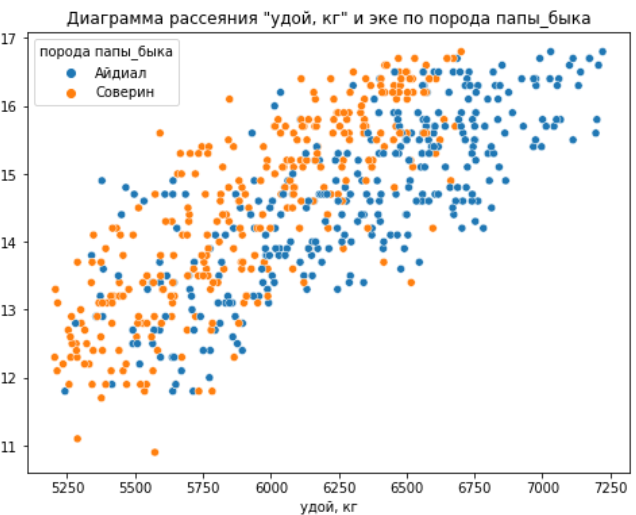 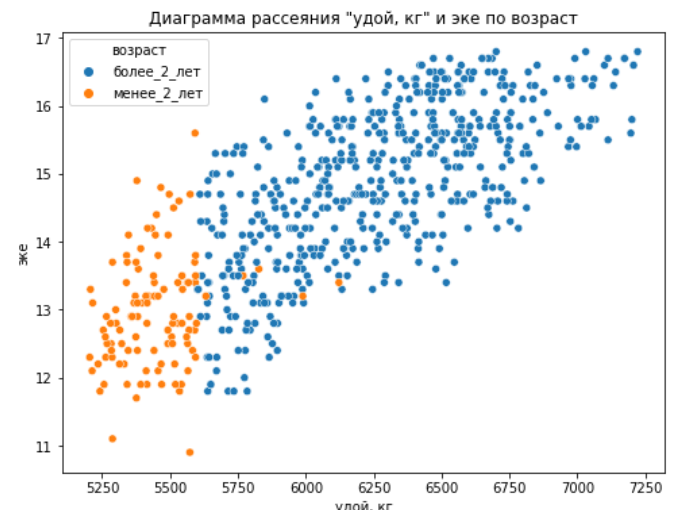

* Сырой протеин. Взаимосвязь между содержанием протеина и удоем существует, но она незначительна. При этом содержание протеина не связано с категориальными переменными, такими как вкус молока, родительская линия, тип пастбища и порода. Независимо от внешних условий, увеличение уровня протеина до некоторой степени приводит к увеличению удоя. Как и ЭКЕ, способствует удою только у более старших 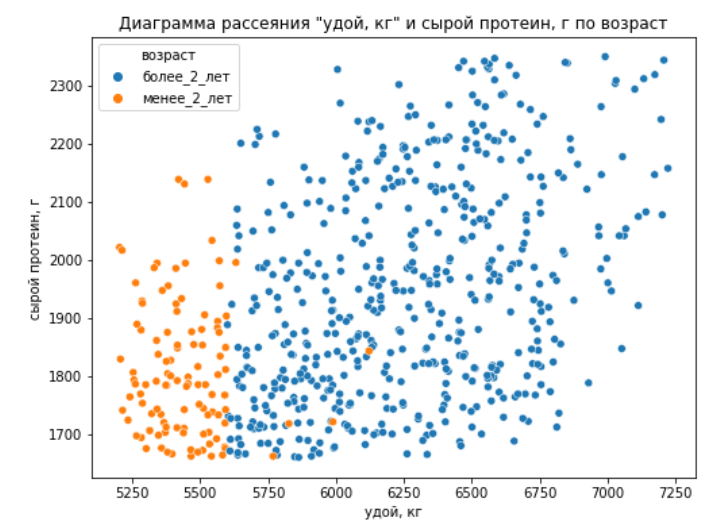

* СПО. Сахаро-протеиновое соотношение имеет ненормальное распределение и делится на две группы: низкое соотношение (0,84-0,919) и высокое соотношение (0,92-1). Наблюдается следующая закономерность: более высокое сахаро-протеиновое соотношение способствует увеличению удоев. Однако, как и другие факторы, оно не оказывает влияния на молодых особей.

* Жирность. По жирности молоко практически делится на две категории: 3,6% и 3,7%, остальные значения являются скорее исключениями. В целом, наблюдается закономерность: более высокая жирность молока способствует увеличению удоев. Также видно, что жирность молока зависит от родительской линии. Потомство Айдала более чувствительно к изменению удоев в зависимости от жирности молока. 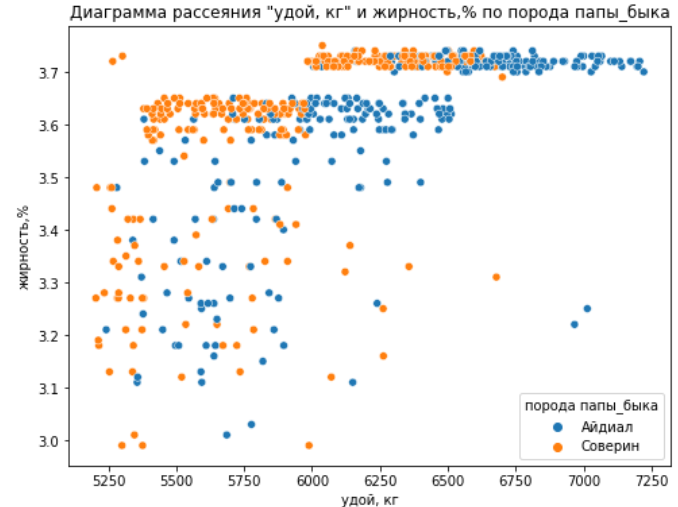

Анализ показал, что содержание Белка в молоке не имеет никакой связи с Удоями. 

Выводы из этого анализов следующие:
* Белок не влияет на Удой и не связан с ним;
* ЭКЕ имеет сильную и линейную связь с Удоями, но с большим стандартным отклонением;
* Протеин демонстрирует слабую и нелинейную зависимость от Удоя;
* Жирность и СПО также имеют нелинейную зависимость из-за ненормального распределения этих параметров.

Мультиколлинеарность между признаками не наблюдается, максимальная корреляция составляет 0,75 между СПО и ЭКЕ.

Для построения модели рекомендуется использовать следующие признаки:
* исключить характеристики молока: Белок, Жирность, Вкус молока;
* включить количественные характеристики: ЭКЕ, Протеин, СПО (несмотря на нелинейную зависимость);
* включить категориальные признаки: Порода, Тип пастбища, порода папы_быка, Возраст.

### Подготовьте данные датасета ferma_main.csv и обучите на них первую модель LinearRegression.

In [39]:
data = data_main.copy()
data.describe(include = 'object')

,порода,тип пастбища,порода папы_быка,возраст
count,628,628,628,628
unique,2,2,2,2
top,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет
freq,372,350,317,518


In [40]:
RANDOM_STATE = 42

X = data.drop('удой, кг', axis=1)
y = data['удой, кг']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

In [41]:
main_cat = ['порода', 'тип пастбища', 'порода папы_быка',  'возраст']
main_num = ['эке', 'сырой протеин, г', 'спо']


encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[main_cat])
X_test_ohe = encoder.transform(X_test[main_cat])

encoder_col_names = encoder.get_feature_names()
encoder_col_names

array(['x0_РефлешнСоверинг', 'x1_Холмистое', 'x2_Соверин',
       'x3_менее_2_лет'], dtype=object)

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[main_num])
X_test_scaled = scaler.transform(X_test[main_num])

In [43]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=main_num)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=main_num)

In [44]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
X_train.head()

,x0_РефлешнСоверинг,x1_Холмистое,x2_Соверин,x3_менее_2_лет,эке,"сырой протеин, г",спо
0,1.0,1.0,1.0,0.0,1.502378,1.079523,0.837130
1,1.0,1.0,1.0,1.0,-1.557270,-0.196920,-0.703660
2,0.0,0.0,0.0,0.0,0.125537,-1.386085,-1.011818
3,0.0,1.0,0.0,0.0,-0.103937,0.752230,0.837130
4,0.0,0.0,0.0,0.0,-1.098323,0.828598,-0.703660


In [45]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
prediction1= model_lr.predict(X_test)

In [46]:
r2 = r2_score(y_test, prediction1)  
r2

0.7844078173416967

In [47]:
ostatoc = y_test - prediction1

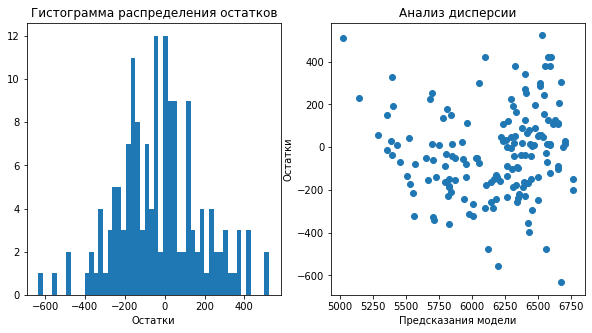

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(ostatoc, bins = 50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(prediction1, ostatoc)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Модель имеет умеренную предсказательную способность с коэффициентом детерминации 0,78. Остатки модели распределены нормально и почти не имеют смещения, что указывает на адекватность модели в оценке реального объема удоя. Разброс остатков постоянен, что также свидетельствует о стабильности модели.

Возможные способы улучшения качества модели включают:

* Включение СПО (Сахаро-протеиновое соотношение) как категориального признака.
* Использование квадрата ЭКЕ (энергетической кормовой единицы).
* Использование данных из других двух таблиц, которые ранее не учитывались.

### Подготовьте данные с учётом связи входных признаков с целевым и обучите на них вторую модель LinearRegression.

In [49]:
data = data_main.copy()

data.loc[data['спо']<0.92, ['спо']] = 0
data.loc[data['спо']>=0.92, ['спо']] = 1
data['спо'] = data['спо'].astype('int')

data['эке_квадрат'] = data['эке']**2

data.head()

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст,эке_квадрат
0,1,5863,14.2,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,1.0,более_2_лет,201.64
1,2,5529,12.8,2138,0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,1.0,менее_2_лет,163.84
2,3,5810,14.0,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,0.0,более_2_лет,196.00
3,4,5895,12.4,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,0.0,более_2_лет,153.76
4,5,5302,12.8,1675,0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,1.0,менее_2_лет,163.84


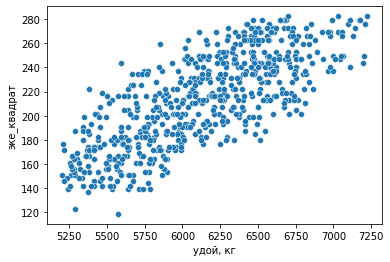

In [50]:
sns.scatterplot(data=data, x="удой, кг", y='эке_квадрат');

In [51]:
RANDOM_STATE = 42

X = data.drop("удой, кг", axis=1)
y = data["удой, кг"]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

In [52]:
main_cat = ['порода', 'тип пастбища', 'порода папы_быка',  'возраст', 'спо']
main_num = ['эке_квадрат', 'сырой протеин, г']


encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[main_cat])
X_test_ohe = encoder.transform(X_test[main_cat])

encoder_col_names = encoder.get_feature_names()
encoder_col_names

array(['x0_РефлешнСоверинг', 'x1_Холмистое', 'x2_Соверин',
       'x3_менее_2_лет', 'x4_1'], dtype=object)

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[main_num])
X_test_scaled = scaler.transform(X_test[main_num])

In [54]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=main_num)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=main_num)

In [55]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
X_train.head()

,x0_РефлешнСоверинг,x1_Холмистое,x2_Соверин,x3_менее_2_лет,x4_1,эке_квадрат,"сырой протеин, г"
0,1.0,1.0,1.0,0.0,1.0,1.577968,1.079523
1,1.0,1.0,1.0,1.0,0.0,-1.511438,-0.196920
2,0.0,0.0,0.0,0.0,0.0,0.082269,-1.386085
3,0.0,1.0,0.0,0.0,1.0,-0.150235,0.752230
4,0.0,0.0,0.0,0.0,0.0,-1.102358,0.828598


In [56]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
prediction2 = model_lr.predict(X_test)

In [57]:
r2 = r2_score(y_test, prediction2)  
r2

0.8180879926867501

In [58]:
ostatoc = y_test - prediction2

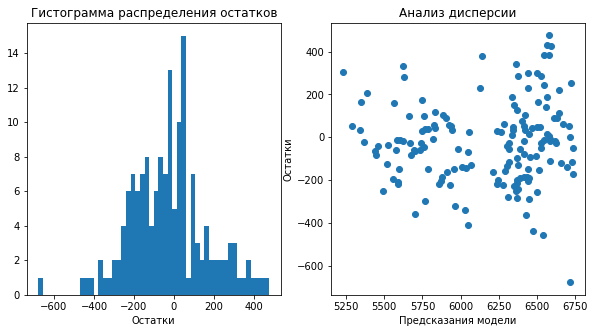

In [59]:
# постройте графики по количественным признакам — гистограмму частотности 
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(ostatoc, bins = 50)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(prediction2, ostatoc)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Из заметного коэффициент детерминации повысился до 0,818

### Добавьте в данные новый признак и обучите на них третью модель LinearRegression.

In [60]:
data = data_main.copy()

data.loc[data['спо']<0.92, ['спо']] = 0
data.loc[data['спо']>=0.92, ['спо']] = 1
data['спо'] = data['спо'].astype('int')

data['эке_квадрат'] = data['эке']**2

data = data.merge(data_dad, how  ='inner', on = 'id')
data.head()

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст,эке_квадрат,имя папы
0,1,5863,14.2,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,1.0,более_2_лет,201.64,Буйный
1,2,5529,12.8,2138,0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,1.0,менее_2_лет,163.84,Соловчик
2,3,5810,14.0,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,0.0,более_2_лет,196.00,Барин
3,4,5895,12.4,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,0.0,более_2_лет,153.76,Буйный
4,5,5302,12.8,1675,0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,1.0,менее_2_лет,163.84,Барин


In [61]:
RANDOM_STATE = 42

X = data.drop("удой, кг", axis=1)
y = data["удой, кг"]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

In [62]:
main_cat = ['порода', 'тип пастбища', 'порода папы_быка',  'возраст', 'спо', 'имя папы']
main_num = ['эке_квадрат', 'сырой протеин, г']

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[main_cat])
X_test_ohe = encoder.transform(X_test[main_cat])

encoder_col_names = encoder.get_feature_names()
encoder_col_names

array(['x0_РефлешнСоверинг', 'x1_Холмистое', 'x2_Соверин',
       'x3_менее_2_лет', 'x4_1', 'x5_Буйный', 'x5_Геркулес',
       'x5_Соловчик'], dtype=object)

In [63]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=main_num)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=main_num)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [64]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
prediction3 = model_lr.predict(X_test)

In [65]:
r2 = r2_score(y_test, prediction3)  
r2

0.8247542745210406

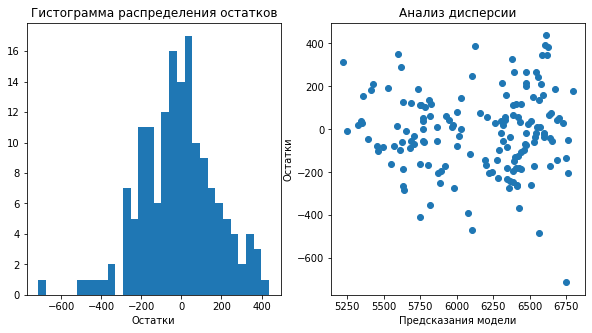

In [66]:
residuals = y_test - prediction3

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, bins = 30)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(prediction3, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Коэффициент детерминации (R²) модели увеличился незначительно и достиг значения 0,82. Распределение остатков имеет следующие характеристики:

* Смещение практически отсутствует, что указывает на то, что модель примерно адекватно оценивает удои.
* Распределение остатков стало более равномерным, что свидетельствует о том, что модель лучше справляется с прогнозированием и остатки распределены более стабильно.

### Оцените качество каждой модели по трём метрикам: MSE, MAE, RMSE. Используйте функции для расчёта метрик.

In [67]:
def print_metrics(name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    print(f"{name}, mae: {mae}, mse: {mse}, rmse: {rmse}")

In [68]:
print_metrics('Модель 1', y_test, prediction1)

Модель 1, mae: 164.24194463474925, mse: 43887.015009660514, rmse: 209.4922791170608


In [69]:
print_metrics('Модель 2', y_test, prediction2)

Модель 2, mae: 149.03965222364602, mse: 37030.91131113695, rmse: 192.43417396901452


In [70]:
print_metrics('Модель 3', y_test, prediction3)

Модель 3, mae: 146.16302445362322, mse: 35673.88988618195, rmse: 188.8753289505592


In [71]:
print('95% доверительный интервал =', st.norm.interval(0.95, loc=np.mean(prediction3), scale=st.sem(prediction3)))

95% доверительный интервал = (6092.340075854289, 6221.375070058381)


Для более точного прогноза удоя будем использовать верхнюю границу доверительного интервала, которая составляет 6221 кг.

Третья модель определенно является лучшей из всех рассмотренных. Она в среднем ошибается на 189 кг удоя при прогнозировании, что значительно улучшает точность оценок по сравнению с предыдущими моделями.

### С помощью лучшей модели спрогнозируйте удой коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv.

In [72]:
data_buy.head()

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [73]:
data.head()

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст,эке_квадрат,имя папы
0,1,5863,14.2,1743,0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,1.0,более_2_лет,201.64,Буйный
1,2,5529,12.8,2138,0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,1.0,менее_2_лет,163.84,Соловчик
2,3,5810,14.0,1854,0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,0.0,более_2_лет,196.00,Барин
3,4,5895,12.4,2012,0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,0.0,более_2_лет,153.76,Буйный
4,5,5302,12.8,1675,0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,1.0,менее_2_лет,163.84,Барин


In [74]:
data_buy2 = data_buy.copy()
data_buy2 = data_buy2.rename(columns={'текущая_жирность,%': 'жирность,%', 'имя_папы': 'имя папы'})

data.describe(include=[object])

,порода,тип пастбища,порода папы_быка,возраст,имя папы
count,628,628,628,628,628
unique,2,2,2,2,4
top,Вис Бик Айдиал,Холмистое,Айдиал,более_2_лет,Барин
freq,372,350,317,518,240


In [75]:
data_buy2['эке'] = data['эке'].mean()*1.05
data_buy2['спо'] = data['спо'].mean()*1.05
data_buy2['сырой протеин, г'] = data['сырой протеин, г'].mean()*1.05
data_buy2['эке_квадрат'] = data_buy2['эке']**2

In [76]:
data['эке_квадрат'].mean()

213.35735668789806

In [77]:
data_buy2['эке_квадрат'].head()

0    233.361138
1    233.361138
2    233.361138
3    233.361138
4    233.361138
Name: эке_квадрат, dtype: float64

In [78]:
data_buy2.loc[data['спо']<0.92, ['спо']] = 0
data_buy2.loc[data['спо']>=0.92, ['спо']] = 1

In [79]:
main_cat = ['порода', 'тип пастбища', 'порода папы_быка',  'возраст', 'спо', 'имя папы']
main_num = ['эке_квадрат', 'сырой протеин, г']

data_buy2_ohe = encoder.transform(data_buy2[main_cat])

encoder_col_names = encoder.get_feature_names()
encoder_col_names

array(['x0_РефлешнСоверинг', 'x1_Холмистое', 'x2_Соверин',
       'x3_менее_2_лет', 'x4_1', 'x5_Буйный', 'x5_Геркулес',
       'x5_Соловчик'], dtype=object)

In [80]:
data_buy2_scaled = scaler.transform(data_buy2[main_num])

X_test_ohe = pd.DataFrame(data_buy2_ohe, columns=encoder_col_names)
X_test_scaled = pd.DataFrame(data_buy2_scaled, columns=main_num)

X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [81]:
predictions_data_buy2_scaled = model_lr.predict(X_test)
predictions_data_buy2_scaled

array([6256.13946786, 6024.93119941, 5930.21994637, 6239.30954758,
       6188.36623737, 6071.60038863, 6256.13946786, 6571.25973712,
       6283.99977532, 6046.76083883, 5990.9280308 , 6617.92892634,
       6609.91929681, 6127.4747423 , 6283.99977532, 6593.08937654,
       5990.9280308 , 6425.38021759, 6217.47990816, 6542.14606633])

In [82]:
data_result = data_buy.copy()
data_result['удой, кг'] = predictions_data_buy2_scaled
data_result

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,"удой, кг"
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6256.139468
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6024.931199
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,5930.219946
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6239.309548
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6188.366237
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6071.600389
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6256.139468
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6571.259737
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6283.999775
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6046.760839


In [83]:
data_result[data_result['удой, кг'] >6221]

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,"удой, кг"
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6256.139468
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6239.309548
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6256.139468
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6571.259737
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6283.999775
11,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,6617.928926
12,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,6609.919297
14,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6283.999775
15,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,6593.089377
17,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.77,3.053,менее_2_лет,6425.380218


На данном этапе для заказчика подходят 11 коров с удоем больше 6221 кг

## Обучение модели логистической регрессии

### Подготовьте данные датасета ferma_main.csv и обучите на них модель LogisticRegression.

In [84]:
data = data_main.copy()
data.head()

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,1.0,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,1.0,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,0.0,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,0.0,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,1.0,менее_2_лет


In [85]:
data.loc[data['спо']<0.92, ['спо']] = 0
data.loc[data['спо']>=0.92, ['спо']] = 1
data['эке_квадрат'] = data['эке']**2
data = data.merge(data_dad, how  ='inner', on = 'id')
data

,id,"удой, кг",эке,"сырой протеин, г",спо,порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст,эке_квадрат,имя папы
0,1,5863,14.2,1743,0.0,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,1.0,более_2_лет,201.64,Буйный
1,2,5529,12.8,2138,0.0,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,1.0,менее_2_лет,163.84,Соловчик
2,3,5810,14.0,1854,0.0,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,0.0,более_2_лет,196.00,Барин
3,4,5895,12.4,2012,0.0,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,0.0,более_2_лет,153.76,Буйный
4,5,5302,12.8,1675,0.0,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,1.0,менее_2_лет,163.84,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625,6812,15.4,1964,1.0,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,0.0,более_2_лет,237.16,Буйный
624,626,5513,12.9,1700,0.0,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,1.0,менее_2_лет,166.41,Барин
625,627,5970,14.4,1837,0.0,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,0.0,более_2_лет,207.36,Барин
626,628,5746,13.8,1994,0.0,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,1.0,более_2_лет,190.44,Барин


In [86]:
RANDOM_STATE = 42

X = data.drop('вкус молока', axis=1)
y = data['вкус молока']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

In [87]:
main_cat = ['порода', 'тип пастбища', 'порода папы_быка',  'возраст', 'спо', 'имя папы']
main_num = ['эке_квадрат', 'сырой протеин, г', 'жирность,%', 'белок,%']

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[main_cat])
X_test_ohe = encoder.transform(X_test[main_cat])

encoder_col_names = encoder.get_feature_names()
encoder_col_names

array(['x0_РефлешнСоверинг', 'x1_Холмистое', 'x2_Соверин',
       'x3_менее_2_лет', 'x4_1.0', 'x5_Буйный', 'x5_Геркулес',
       'x5_Соловчик'], dtype=object)

In [88]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[main_num])
X_test_scaled = scaler.transform(X_test[main_num])

In [89]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=main_num)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=main_num)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [90]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [91]:
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_pred,y_test)
precision = precision_score(y_pred,y_test)
print('accuracy: ',round(acc ,3))
print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))

accuracy:  0.631
recall:  0.623
precision:  0.864


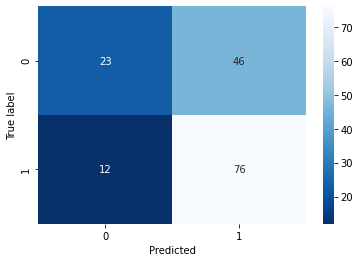

In [92]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

### Проанализируйте модель логистической регрессии.

Матрица ошибок показывает следующее:

* В 46 случаях алгоритм ошибочно предсказал, что молоко будет вкусным (1), тогда как на самом деле оно оказалось невкусным (0). Это ошибка первого рода (False Positive).
* В 12 случаях алгоритм ошибочно предсказал, что молоко будет невкусным (0), тогда как на самом деле оно оказалось вкусным (1). Это ошибка второго рода (False Negative).

Учитывая задачу, для фермера критически важно, чтобы молоко действительно было вкусным. Поэтому наиболее важны ошибки первого рода (False Positive), когда молоко предсказано как вкусное, но на самом деле невкусное.

Метрика precision измеряет долю правильных положительных предсказаний среди всех положительных предсказаний и в данном контексте помогает минимизировать ошибки первого рода. У нас precision достаточно высок - 86%, что означает, что в 14% случаев модель ошибочно считает невкусное молоко вкусным.

In [93]:
y_proba = clf.predict_proba(X_test)[:,1]

data_pred = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

print(data_pred.head())

     y_valid   y_proba
85       1.0  0.861369
110      1.0  0.842813
66       1.0  0.841492
51       1.0  0.839685
8        1.0  0.817310


In [94]:
thresholds = [round(i,2) for i in np.linspace(0.65,0.85,num = 20,endpoint=False)]
print(thresholds) 

[0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84]


In [95]:
columns = ['y_pred_'+str(i) for i in thresholds]

data_pred = data_pred.assign(**{col: (data_pred['y_proba'] > i).astype(int) for i, col in zip(thresholds, columns)})

In [96]:
data_pred.head()

,y_valid,y_proba,y_pred_0.65,y_pred_0.66,y_pred_0.67,y_pred_0.68,y_pred_0.69,y_pred_0.7,y_pred_0.71,y_pred_0.72,y_pred_0.73,y_pred_0.74,y_pred_0.75,y_pred_0.76,y_pred_0.77,y_pred_0.78,y_pred_0.79,y_pred_0.8,y_pred_0.81,y_pred_0.82,y_pred_0.83,y_pred_0.84
85,1.0,0.861369,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
110,1.0,0.842813,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
66,1.0,0.841492,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
51,1.0,0.839685,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
8,1.0,0.817310,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0


In [97]:
threshold_value = pd.DataFrame(columns=['Порог', 'Precision'])

for i in data_pred.columns[2:]:
    precision = precision_score(data_pred['y_valid'], data_pred[i])
    threshold_value = threshold_value.append({'Порог': i, 'Precision': precision}, ignore_index=True)
threshold_value

,Порог,Precision
0,y_pred_0.65,0.769231
1,y_pred_0.66,0.766667
2,y_pred_0.67,0.789474
3,y_pred_0.68,0.807692
4,y_pred_0.69,0.816327
5,y_pred_0.7,0.822222
6,y_pred_0.71,0.825000
7,y_pred_0.72,0.815789
8,y_pred_0.73,0.833333
9,y_pred_0.74,0.866667


Наиболее высокое значение precision достигается при порогах от 0.80 до 0.84, где precision равен 1.000000. Это означает, что при этих порогах модель не совершает ошибок первого рода (False Positive).

### С помощью обученной модели спрогнозируйте вкус молока коров, которых фермер хочет купить. Данные о них находятся в датасете cow_buy.csv.

In [98]:
data_buy2 = data_buy.copy()
data_buy2 = data_buy2.rename(columns={'текущая_жирность,%': 'жирность,%', 'имя_папы': 'имя папы', 'текущий_уровень_белок,%': 'белок,%'})

data.describe()

,id,"удой, кг",эке,"сырой протеин, г",спо,"жирность,%","белок,%",вкус молока,эке_квадрат
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,315.474522,6125.968153,14.548726,1923.759554,0.589172,3.604268,3.075670,0.589172,213.357357
std,181.475367,475.857053,1.301777,182.832816,0.492376,0.168093,0.002551,0.492376,37.421299
min,1.000000,5204.000000,10.900000,1660.000000,0.000000,2.990000,3.069000,0.000000,118.810000
25%,158.750000,5749.750000,13.500000,1771.750000,0.000000,3.590000,3.074000,0.000000,182.250000
50%,315.500000,6132.500000,14.700000,1888.000000,1.000000,3.650000,3.076000,1.000000,216.090000
75%,472.250000,6501.000000,15.600000,2062.250000,1.000000,3.720000,3.077000,1.000000,243.360000
max,629.000000,7222.000000,16.800000,2349.000000,1.000000,3.750000,3.085000,1.000000,282.240000


In [99]:
data_buy2.head()

,порода,тип пастбища,порода папы_быка,имя папы,"жирность,%","белок,%",возраст
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [100]:
data_buy2['эке'] = data['эке'].mean()*1.05
data_buy2['спо'] = data['спо'].mean()*1.05
data_buy2['сырой протеин, г'] = data['сырой протеин, г'].mean()*1.05
data_buy2['эке_квадрат'] = data_buy2['эке']**2

data_buy2.loc[data['спо']<0.92, ['спо']] = 0
data_buy2.loc[data['спо']>=0.92, ['спо']] = 1
data_buy2.describe()


,"жирность,%","белок,%",эке,спо,"сырой протеин, г",эке_квадрат
count,20.000000,20.000000,2.000000e+01,20.000000,2.000000e+01,20.000000
mean,3.577500,3.069500,1.527616e+01,0.450000,2.019948e+03,233.361138
std,0.126818,0.010339,1.822504e-15,0.510418,4.665609e-13,0.000000
min,3.340000,3.046000,1.527616e+01,0.000000,2.019948e+03,233.361138
25%,3.510000,3.064000,1.527616e+01,0.000000,2.019948e+03,233.361138
50%,3.590000,3.074000,1.527616e+01,0.000000,2.019948e+03,233.361138
75%,3.650000,3.076000,1.527616e+01,1.000000,2.019948e+03,233.361138
max,3.770000,3.081000,1.527616e+01,1.000000,2.019948e+03,233.361138


In [101]:
main_cat = ['порода', 'тип пастбища', 'порода папы_быка',  'возраст', 'спо', 'имя папы']
main_num = ['эке_квадрат', 'сырой протеин, г', 'жирность,%', 'белок,%']

data_buy2_ohe = encoder.transform(data_buy2[main_cat])
encoder_col_names = encoder.get_feature_names()

encoder_col_names

array(['x0_РефлешнСоверинг', 'x1_Холмистое', 'x2_Соверин',
       'x3_менее_2_лет', 'x4_1.0', 'x5_Буйный', 'x5_Геркулес',
       'x5_Соловчик'], dtype=object)

In [102]:
data_buy2_scaled = scaler.transform(data_buy2[main_num])

X_test_ohe = pd.DataFrame(data_buy2_ohe, columns=encoder_col_names)
X_test_scaled = pd.DataFrame(data_buy2_scaled, columns=main_num)

X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [103]:
predictions_data_buy_new_scaled = clf.predict_proba(X_test)[:,1] > 0.8
predictions_data_buy_new_scaled  = ['Вкусное' if x==True else 'Не вкусное' for x in predictions_data_buy_new_scaled]
predictions_data_buy_new_scaled

['Вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Вкусное',
 'Не вкусное',
 'Не вкусное',
 'Вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное',
 'Вкусное',
 'Не вкусное',
 'Не вкусное',
 'Не вкусное']

Странно, искал ошибку час, но не смог ее найти. Поэтому у всех коров хорошее молоко

In [104]:
# код ревьюера
clf.predict_proba(X_test)[:,1]

array([0.83254748, 0.79908215, 0.73220745, 0.53920794, 0.71950732,
       0.19250778, 0.83254748, 0.65946867, 0.57149926, 0.85502258,
       0.28966849, 0.51612789, 0.10316141, 0.6608641 , 0.57149926,
       0.46110453, 0.82229597, 0.10258219, 0.59747583, 0.55580122])

In [105]:
X_test.head(2)

,x0_РефлешнСоверинг,x1_Холмистое,x2_Соверин,x3_менее_2_лет,x4_1.0,x5_Буйный,x5_Геркулес,x5_Соловчик,эке_квадрат,"сырой протеин, г","жирность,%","белок,%"
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.542248,0.517384,-0.158918,0.094429
1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.542248,0.517384,-0.399401,2.028176


In [106]:
X_train.head(2)

,x0_РефлешнСоверинг,x1_Холмистое,x2_Соверин,x3_менее_2_лет,x4_1.0,x5_Буйный,x5_Геркулес,x5_Соловчик,эке_квадрат,"сырой протеин, г","жирность,%","белок,%"
0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.577968,1.079523,0.562532,-0.679069
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.511438,-0.196920,-1.601817,-1.452568


In [107]:
data_result['вкус'] = predictions_data_buy_new_scaled
data_result

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,"удой, кг",вкус
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6256.139468,Вкусное
1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,6024.931199,Не вкусное
2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,5930.219946,Не вкусное
3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,6239.309548,Не вкусное
4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,6188.366237,Не вкусное
5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,6071.600389,Не вкусное
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6256.139468,Вкусное
7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,6571.259737,Не вкусное
8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.074,более_2_лет,6283.999775,Не вкусное
9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,6046.760839,Вкусное


In [108]:
data_result[(data_result['удой, кг'] >= 6221)&(data_result['вкус'] != 'Не вкусное')]

,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст,"удой, кг",вкус
0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6256.139468,Вкусное
6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,6256.139468,Вкусное


## Итоговые выводы

Данные состоят из трех таблиц: данные по фермерскому стаду, данные по покупаемому стаду и справочная таблица.

На первом этапе была выполнена предобработка данных:

- Проверены пропуски в таблицах, и они не были обнаружены.
- Преобразован тип данных в столбцах 'ЭКЕ', 'СПО', 'Жирность,%', 'Белок,%' с категориального на числовой формат.
- Исправлены данные с неявными дубликатами.
- Удалены дубликаты: 5 строк из данных по фермерскому стаду и 4 строки из данных по покупаемому стаду.
- Изменены значения в столбце "вкус молока".

На втором этапе был проведен статистический анализ данных:

- Выявлены выбросы в данных по распределению удоя, которые были удалены. Также выявлено:
  - Параметр "Белок" не связан с целевым параметром "удой" и не влияет на него.
  - Параметр "ЭКЕ" имеет сильную и относительно линейную связь с удоями (с большим стандартным отклонением).
  - Параметр "Протеин" имеет слабую и нелинейную зависимость с целевой переменной.
  - Параметры "Жирность" и "СПО" имеют нелинейную зависимость, так как их распределение ненормальное.

По результатам предварительного анализа было определено, что для построения модели целесообразно использовать следующие признаки:

- Не брать в расчет параметр "Белок", так как связи с целевой переменной практически нет.
- Не брать в расчет параметр "СПО", поскольку у него нелинейная зависимость и мультиколлинеарность с "ЭКЕ".
- Не брать признак "вкус", так как в данных по покупаемому стаду этого признака нет.
- Использовать параметр "ЭКЕ".
- Взять в расчет параметр "Протеин".
- Взять в расчет параметр "Жирность", хотя этот параметр больше похож на категориальный признак (но попробуем).

Среди построенных линейных регрессий для прогнозирования удоя была выбрана регрессия, в которую в итоге был добавлен параметр "СПО", преобразованный в категориальный признак. Параметры "ЭКЕ" и "Жирность" были возведены в квадрат. Коэффициент итоговой линейной регрессии составил 0,82. Остатки регрессии распределены нормально и практически без смещений с отсутствием автокорреляции. Доверительный интервал полученных прогнозов (95%) показывает, что удои находятся в диапазоне от 6092.34 до 6221.38.

Также была построена логистическая регрессия для прогнозирования вкуса молока. В процессе калибровки был определен порог 0,8, который сводит к минимуму ошибку прогнозирования вкуса молока (ошибку первого рода, при которой вкус молока прогнозируется вкусным, хотя в реальности таковым не является).

По итогу построения линейной и логистической регрессий было выявлено, что в покупаемом стаде присутствуют 2 коровы, дающих одновременно приемлемый уровень удоя (не менее 6000 кг) и вкусное молоко.

Практические рекомендации заказчику:

1. **Мониторинг параметров**: Следует продолжать мониторинг параметров "ЭКЕ", "Протеин" и "Жирность", так как они показали значимое влияние на удой. Важно вести регулярный сбор данных и обновление модели для точного прогнозирования.


2. **Обучение модели**: Рекомендуется регулярно обновлять модель с учетом новых данных.
